20.31 17.36
35.12 35.22
31.85 29.44


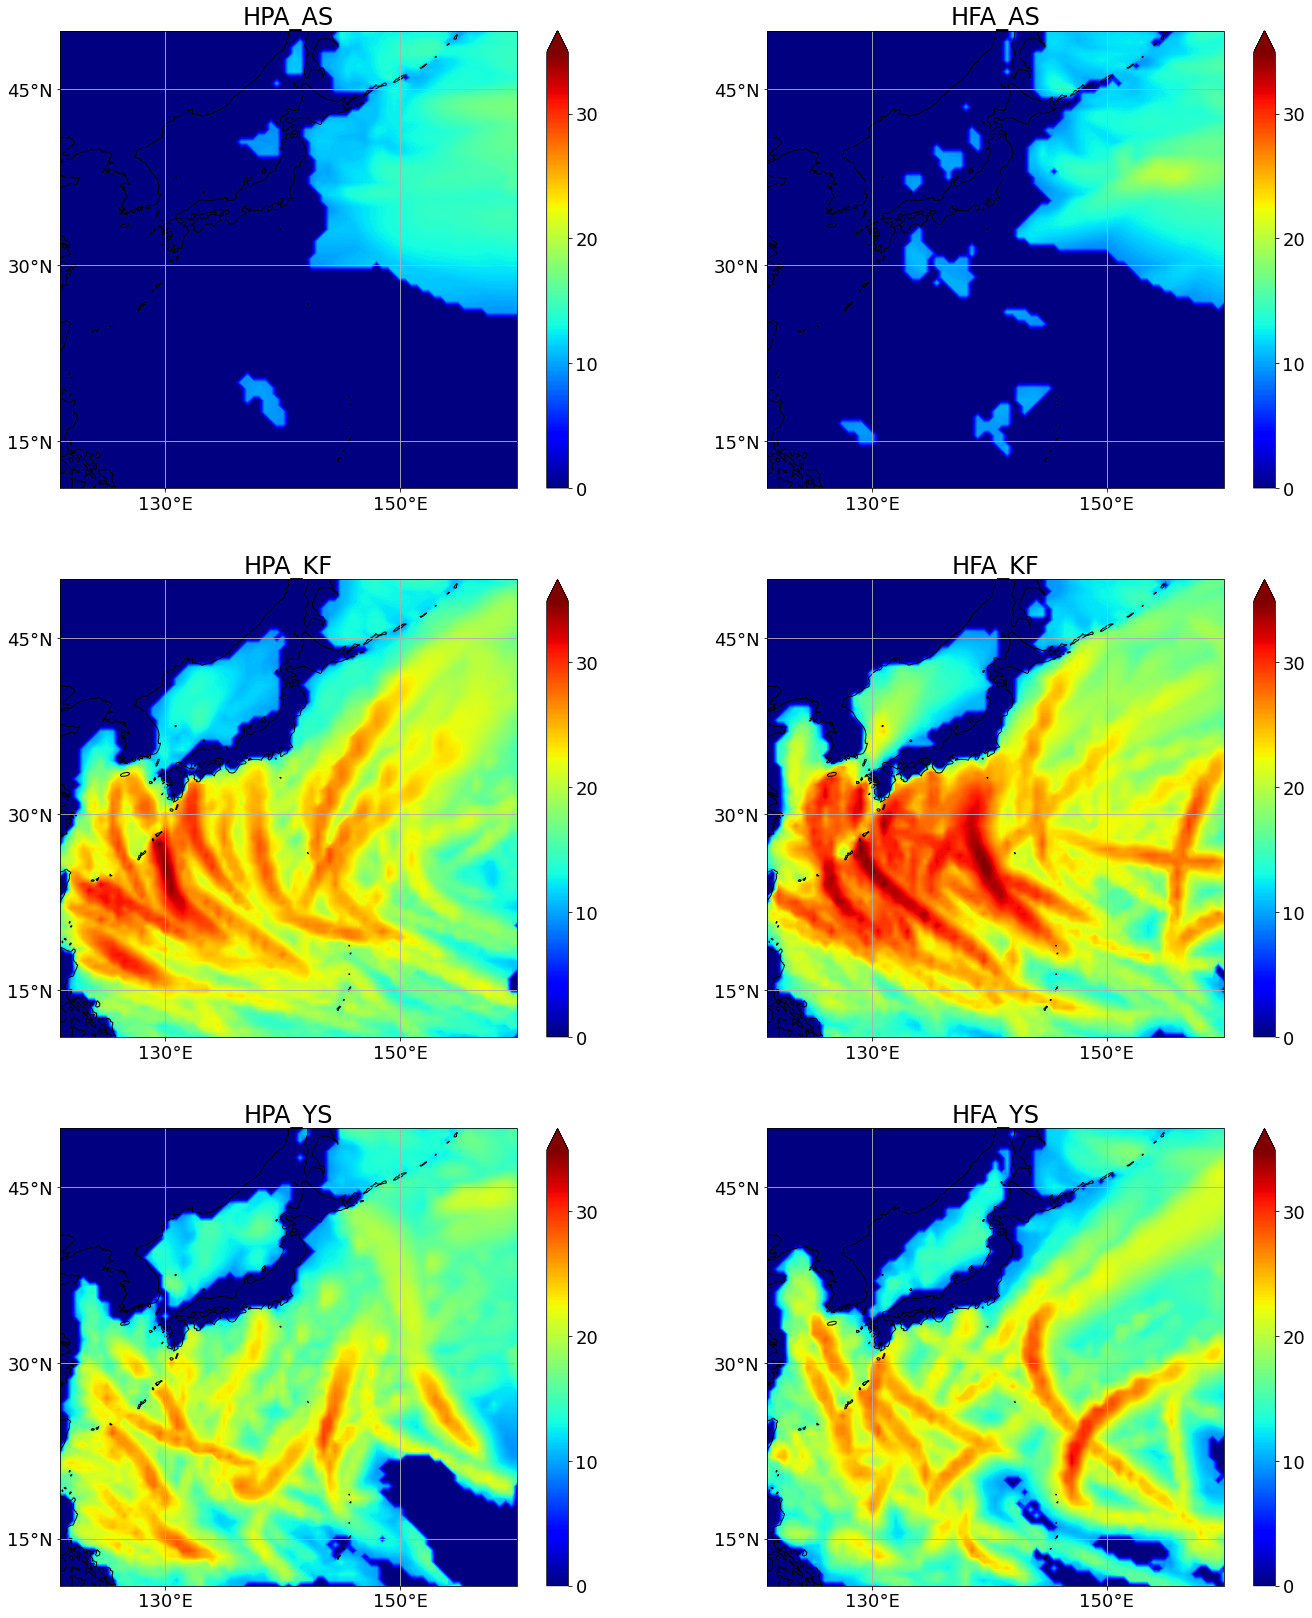

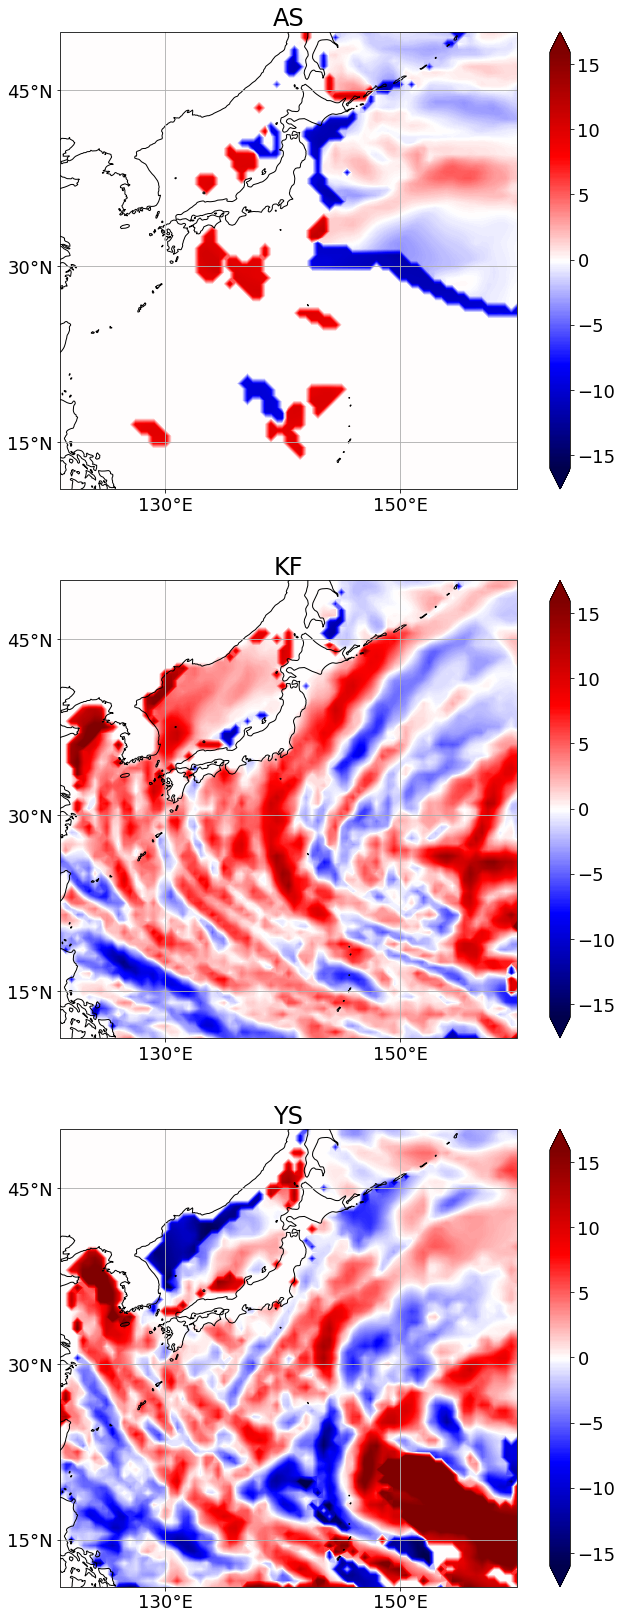

In [7]:
from csv import reader
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import copy
import matplotlib as mpl
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker

"""モデル間の最大値比較の図を出力"""

MODEL = ['AS', 'KF', 'YS']

with open('../lats.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    lats = list(csv_reader)
with open('../lons.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    lons = list(csv_reader)

for i in range(79):
    for j in range(79):
        lats[i][j] = float(lats[i][j])
        lons[i][j] = float(lons[i][j])

lat_s = lats[0][0]
lat_n = lats[0][-1]
lon_w = lons[0][0]
lon_e = lons[-1][0]

DATA_F = []
DATA_P = []

LOCATION = []

for i in range(len(MODEL)):
    # モデル名
    model = MODEL[i]
    # 各地点の最大値
    data_f = np.zeros((79, 79))  # 未来
    data_p = np.zeros((79, 79))  # 過去

    # 将来
    with open('../pot_csv/' + 'HFA_' + model + '_c0_POT_DATA_108.csv', 'r') as csv_file:
        csv_reader = reader(csv_file)
        POT_ALL = list(csv_reader)
        for index in range(79 * 79):
            POT = POT_ALL[index]
            s = [float(val) for val in POT]
            if len(s) > 1:
                data_f[index // 79][index % 79] = max(s)
            else:
                data_f[index // 79][index % 79] = 0
    # 過去
    with open('../pot_csv/' + 'HPA_' + model + '_POT_DATA_108.csv', 'r') as csv_file:
        csv_reader = reader(csv_file)
        POT_ALL = list(csv_reader)
        for index in range(79 * 79):
            POT = POT_ALL[index]
            s = [float(val) for val in POT]
            if len(s) > 1:
                data_p[index // 79][index % 79] = max(s)
            else:
                data_p[index // 79][index % 79] = 0
    print(np.max(data_f), np.max(data_p))
    DATA_F.append(data_f)
    DATA_P.append(data_p)
    idx = np.where(data_f >= 24.170000305175783) # 異常値除去
    for i in range(len(idx[0])):
        LOCATION.append(79 * idx[0][i] + idx[1][i])

# 描画(現在気候の最大値)
fig = plt.figure(figsize=(20, 24))
levels = np.arange(0, 35, 0.1)
cmap = copy.copy(mpl.cm.get_cmap("jet"))
for i in range(6):
    ax = fig.add_subplot(3, 2, i + 1, projection=ccrs.PlateCarree())
    if i % 2 == 0:
        a = plt.contourf(lons, lats, DATA_P[i // 2], levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='max')
    else:
        a = plt.contourf(lons, lats, DATA_F[i // 2], levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='max')
    c_bar = plt.colorbar(a, ticks=[0, 10, 20, 30])
    c_bar.ax.tick_params(labelsize=18)
    c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
    ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
    ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
    lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
    lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.axes.tick_params(labelsize=18)
    ax.grid()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
    gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
    gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線
    ax.coastlines()
    if i % 2 == 0:
        ax.set_title('HPA_' + MODEL[i // 2], fontsize=24)
    else:
        ax.set_title('HFA_' + MODEL[i // 2], fontsize=24)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig("../img/max_data.png")
plt.show()

# 描画(将来気候と現在気候の最大値の差)
fig = plt.figure(figsize=(10, 24))
levels = np.arange(-16, 16, 0.1)
cmap = copy.copy(mpl.cm.get_cmap("seismic"))
for i in range(3):
    ax = fig.add_subplot(3, 1, i + 1, projection=ccrs.PlateCarree())
    a = plt.contourf(lons, lats, DATA_F[i] - DATA_P[i], levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    c_bar = plt.colorbar(a, ticks=[-15, -10, -5, 0, 5, 10, 15])
    c_bar.ax.tick_params(labelsize=18)
    c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
    ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
    ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
    lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
    lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.axes.tick_params(labelsize=18)
    ax.grid()
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
    gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
    gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線
    ax.set_title(MODEL[i], fontsize=24)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig("../img/diff_of_max_data.png")
plt.show()